<H1>COMP4531 Deep Learning Mid-Term</H1>

In this project, we will be developing a basic neural network from the ground up to classify various types of fashion items. The primary objective of this project is to gain a comprehensive understanding of neural network architecture, including its theory and implementation details.

Categories in the dataset:

    0: T-shirt/top
    1: Trouser
    2: Pullover
    3: Dress
    4: Coat
    5: Sandal
    6: Shirt
    7: Sneaker
    8: Bag
    9: Ankle boot


<H2>Part 0: Initialization</H2>

To start, let's load some packages and the dataset

In [1]:
# Notice that you don't need any other packages for this mid-term

import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt

random.seed(42) # NEVER change this line; this is for grading

In [2]:
# Reading the dataset
data = pd.read_csv('fashion_data.csv')

In [3]:
# The data pre-processing is done for you. Please do NOT edit the cell
# However, you should understand what these codes are doing

data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:400].T
Y_dev = data_dev[-1]
X_dev = data_dev[0:n-1]
X_dev = X_dev / 255.

data_train = data[400:m].T
Y_train = data_train[-1]
X_train = data_train[0:n-1]
X_train = X_train / 255.
_,m_train = X_train.shape

In [ ]:
Y_train

array([4, 4, 8, ..., 8, 1, 6], dtype=int64)

In [ ]:
X_dev.shape

(784, 400)

In [ ]:
X_train.shape

(784, 1600)

In [ ]:
print(m,n)

2000 785


<H2>Part 1: Building your own neural network</H2>

In [8]:
# define a global variable specifying the number of hidden neurons after the first layer
# not the best practice, but we will do it for this mid-term project
NUM_HIDDEN_NEURONS = 20

This is the main part of the mid-term. You **must not** change the definition of the function. In fact, the comments are going to help you go through the implementation and they are all you need

<H3>1.1 Initialize the parameter in the neural network</H3>

In [9]:
# Initialize the parameters in the neural network

# Based on the figure above, we need the weight and bias matrices. 
# W1, b1 are the matrices for the first layer
# W2, b2 are the matrices for the second layer

# You should think about the sizes of the matrices
# then initialize elements in the matrix to be random numbers between -0.5 to +0.5

def init_params(X: np.ndarray, y: np.ndarray, num_hidden_neurons: int) -> tuple:
    """
    Initialize the weights and biases for the neural network using a random normal distribution 
    for weights and zeros for biases with a range of -0.5 to +0.5.
    Args:
        X (np.ndarray) : training data
        y (np.ndarray) : labels/targets
        num_hidden_neurons (int) : hidden neuron size
    Returns:
        tuple: A tuple containing np.ndarrays
        W1 (np.ndarray): weights of input layer of shape (input_size, num_hidden_neurons)
        b1 (np.ndarray): bias of input layer of shape (num_hidden_neurons, 1)
        W2 (np.ndarray): weights of hidden layer of shape (num_hidden_neurons, output_length)
        b2 (np.ndarray): bias of hidden layer of shape (output_length, 1)
    """

    input_length = X_train.shape[0]
    output_length = len(np.unique(Y_train))

    W1 = np.random.rand(input_length, num_hidden_neurons) - 0.5
    b1 = np.random.rand(num_hidden_neurons, 1) - 0.5 
    W2 = np.random.rand(num_hidden_neurons, output_length) - 0.5
    b2 = np.random.rand(output_length, 1) - 0.5 

    return W1, b1, W2, b2

<H3>1.2 Implement the non-linearity functions and its derivatives</H3>

In [10]:
# As a starting point, you only need a ReLu function, its derivative, and the softmax function 

def ReLU(X: np.ndarray) -> np.ndarray:
    """
    Retrns the ReLU of X.
    Args:
        X (np.ndarray): A numpy array of any shape.
    Returns:
        np.ndarray
    """
    return np.maximum(0,X)

def ReLU_deriv(X: np.ndarray) -> np.ndarray:
    """
    Returns the derivative of ReLU(x).
    Args:
        X (np.ndarray): A numpy array of any shape.
    Returns:
        np.ndarray
    """
    # Relu derivative function
    X[X<=0] = 0
    X[X>0]  = 1
    return X

def softmax(X: np.ndarray) -> np.ndarray:
    """
    Returns the softmax of X.
    Args:
        X (np.ndarray): A numpy array of any shape.
    Returns:
        np.ndarray
    """
    # exp_x = np.exp(X)
    # return exp_x / np.sum(exp_x)
    
    # address overflow
    exp_x = np.exp(X - np.max(X, axis=0, keepdims=True))
    A = exp_x / np.sum(exp_x, axis=0, keepdims=True)
    return A



<H3>1.3 Implement the forward propagation function</H3>

In [11]:
# In the forward propagation function, X is the inputs (the image in vector form), and we pass all the weights and biases

def forward_prop(W1: np.ndarray, b1: np.ndarray,
        W2: np.ndarray,b2: np.ndarray, X: np.ndarray) -> tuple:
    """
    Compute the forward propagation step.
    Args:
        W1 (np.ndarray): weights of input layer of shape (input_size, num_hidden_neurons)
        b1 (np.ndarray): bias of input layer of shape (num_hidden_neurons, 1)
        W2 (np.ndarray): weights of hidden layer of shape (num_hidden_neurons, output_length)
        b2 (np.ndarray): bias of hidden layer of shape (output_length, 1)
        X (np.ndarray): training data of size (input_size, n) where n is the number of samples
    Returns:
        tuple: A tuple containing
          Z1 (np.ndarray): output of the first layer before activation (W1 @ X + b1)
          A1 (np.ndarray): output of the first layer after activation (ReLU(Z1))
          Z2 (np.ndarray): output of the second layer before activation (W2 @ A1 + b2)
          A2 (np.ndarray): output of the second layer after activation (softmax(Z2))
    """
    Z1 = W1.T @ X + b1
    A1 = ReLU(Z1)
    Z2 = W2.T @ A1 + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

<H3>1.4 Implement the backward propagation function</H3>

In [12]:
# This one hot function is to convert a numeric number into a one-hot vector
def one_hot(Y: np.ndarray):
    """
    One hot encode training labels.
    Args:
        Y (np.ndarray) : training labels
    Returns
        (np.ndarray) one-hot encoded training labels
    """
    n_classes = len(np.unique(Y_train))

    one_hot_Y = np.zeros((Y.size, n_classes))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y


# Now performing the backward propagation
# Each function is only one line, but lots of Calculus behind 
def backward_prop(Z1: np.ndarray, A1: np.ndarray, 
        Z2: np.ndarray, A2: np.ndarray, W1: np.ndarray, 
        W2: np.ndarray, X: np.ndarray, Y: np.ndarray) -> tuple:
    """
    Conducts backwards propogation.
    Args:
        Z1 (np.ndarray): output of the first layer before activation (W1 @ X + b1)
        A1 (np.ndarray): output of the first layer after activation (ReLU(Z1))
        Z2 (np.ndarray): output of the second layer before activation (W2 @ A1 + b2)
        A2 (np.ndarray): output of the second layer after activation (softmax(Z2))
        W1 (np.ndarray): weights of input layer of shape (input_size, num_hidden_neurons)
        W2 (np.ndarray): weights of hidden layer of shape (num_hidden_neurons, output_length)
        X (np.ndarray):  training data of size (input_size, n) where n is the number of samples     
    Returns:
        tuple: A tuple containing
            dW1 (np.ndarray): gradient of the cost with respect to W1
            db1 (np.ndarray): gradient of the cost with respect to b1
            dW2 (np.ndarray): gradient of the cost with respect to W2
            db2 (np.ndarray): gradient of the cost with respect to b2 
    """
    # Get the number of training examples
    m = X.shape[1]
    
    one_hot_Y = one_hot(Y)

    # Calculate the gradient of the loss with respect to Z2 (output of the second layer)
    dZ2 = A2 - one_hot_Y

    # Calculate the gradient of the loss with respect to W2 (weights of the second layer)
    dW2 = A1 @ dZ2.T / m

    # Calculate the gradient of the loss with respect to b2 (bias of the second layer)
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    # Calculate the gradient of the loss with respect to Z1 (output of the first layer before activation)
    dZ1 = W2 @ dZ2 * ReLU_deriv(Z1)

    # Calculate the gradient of the loss with respect to W1 (weights of the first layer)
    dW1 = X @ dZ1.T / m

    # Calculate the gradient of the loss with respect to b1 (bias of the first layer)
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    return dW1, db1, dW2, db2

# Finally, we are ready to update the parameters
def update_params(W1: np.ndarray, b1: np.ndarray, W2: np.ndarray, b2: np.ndarray, 
                  dW1: np.ndarray, db1: np.ndarray, dW2: np.ndarray, db2: np.ndarray, 
                  alpha: float) -> tuple:
    """
    Update the parameters of the neural network using gradient descent.

    Args:
        W1 (np.ndarray): weights of input layer of shape (input_size, num_hidden_neurons)
        b1 (np.ndarray): bias of input layer of shape (num_hidden_neurons, 1)
        W2 (np.ndarray): weights of hidden layer of shape (num_hidden_neurons, output_length)
        b2 (np.ndarray): bias of hidden layer of shape (output_length, 1)
        dW1 (np.ndarray): gradient of the cost with respect to W1
        db1 (np.ndarray): gradient of the cost with respect to b1
        dW2 (np.ndarray): gradient of the cost with respect to W2
        db2 (np.ndarray): gradient of the cost with respect to b2
        alpha (float): learning rate.

    Returns:
        tuple: A tuple containing the updated params
            W1 (np.ndarray): Updated weights of the input layer
            b1 (np.ndarray): Updated biases of the input layer
            W2 (np.ndarray): Updated weights of the hidden layer
            b2 (np.ndarray): Updated biases of the hidden layer
    """
    # update that jawn !
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

<H3>1.5 Performing the gradient descent</H3>

In [13]:
# Implement the helper function. We need to convert the softmax output into a numeric label 
# This is done through get_predictions function
def get_predictions(A2: np.ndarray) -> np.ndarray:
    """
    Convert the softmax output into numeric labels 
    by selecting the index of the highest probability.
    Args:
        A2 (np.ndarray): The output of the softmax layer
            - each col is the probability distribution over classes for a single sample
    Returns:
        np.ndarray: An array of predicted class labels, where each element is the index 
                    of the highest probability class for the corresponding sample.
    """
    return np.argmax(A2, axis=0)

# We also want to have a simple function to compute the accuracy. Notice that "predictions" and "Y" are the same shape
def get_accuracy(predictions: np.ndarray, y: np.ndarray) -> float:
    """
    Compute the accuracy of the predictions compared to the true labels.

    Args:
        predictions (np.ndarray): An array of predicted class labels.
        y (np.ndarray): An array of true class labels.

    Returns:
        float: The accuracy as a percentage (0-100).
    """
    assert predictions.shape == y.shape

    accuracy = sum(y == predictions) / len(y)  
    return accuracy

# Finally, we are ready to implement gradient descent
def gradient_descent(X: np.ndarray, y: np.ndarray, 
                     alpha: float, iterations: int, num_hidden_neurons: int) -> tuple:
    """
    Perform gradient descent to optimize the parameters of the neural network.
    Args:
        X (np.ndarray):  training data of size (input_size, n) where n is the number of samples
        y (np.ndarray): training labels
        alpha (float): learning rate
        iterations (int): number of iterations to perform gradient descent
        num_hidden_neurons (int) : hidden neuron size
    Returns:
        tuple: A tuple containing the optimized parameters:
            - W1 (np.ndarray): optimized weights of the first layer
            - b1 (np.ndarray): optimized biases of the first layer
            - W2 (np.ndarray): optimized weights of the second layer
            - b2 (np.ndarray): optimized biases of the second layer
    """
    W1, b1, W2, b2 = init_params(X, y, num_hidden_neurons=num_hidden_neurons)
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, y))
    return W1, b1, W2, b2

In [14]:
W1, b1, W2, b2 = gradient_descent(
        X=X_train,
        y=Y_train,
        alpha=0.10,
        iterations=500,
        num_hidden_neurons=NUM_HIDDEN_NEURONS)

Iteration:  0
0.161875
Iteration:  10
0.428125
Iteration:  20
0.515625
Iteration:  30
0.57125
Iteration:  40
0.60375
Iteration:  50
0.63125
Iteration:  60
0.65625
Iteration:  70
0.669375
Iteration:  80
0.67875
Iteration:  90
0.69375
Iteration:  100
0.7
Iteration:  110
0.709375
Iteration:  120
0.714375
Iteration:  130
0.720625
Iteration:  140
0.73125
Iteration:  150
0.7325
Iteration:  160
0.734375
Iteration:  170
0.733125
Iteration:  180
0.74375
Iteration:  190
0.74875
Iteration:  200
0.759375
Iteration:  210
0.765
Iteration:  220
0.768125
Iteration:  230
0.770625
Iteration:  240
0.7725
Iteration:  250
0.775
Iteration:  260
0.7775
Iteration:  270
0.778125
Iteration:  280
0.778125
Iteration:  290
0.780625
Iteration:  300
0.784375
Iteration:  310
0.788125
Iteration:  320
0.7925
Iteration:  330
0.795625
Iteration:  340
0.795
Iteration:  350
0.79875
Iteration:  360
0.80125
Iteration:  370
0.8025
Iteration:  380
0.805
Iteration:  390
0.8075
Iteration:  400
0.809375
Iteration:  410
0.811875
I

<H3>1.6 Validation Set Performance</H3>

In [15]:
def make_predictions(X: np.ndarray, W1: np.ndarray, b1: np.ndarray, 
                     W2: np.ndarray, b2: np.ndarray) -> np.ndarray:
    """
    Makes predictions using the trained neural network.
    Args:
        X (np.ndarray): input data of shape (input_size, n) where n is the number of samples
        W1 (np.ndarray): weights of the input layer of shape (input_size, num_hidden_neurons)
        b1 (np.ndarray): biases of the input layer of shape (num_hidden_neurons, 1)
        W2 (np.ndarray): weights of the hidden layer of shape (num_hidden_neurons, output_length)
        b2 (np.ndarray): biases of the hidden layer of shape (output_length, 1)
    Returns:
        np.ndarray: An array of predicted class labels, where each element is the index 
                    of the highest probability class for the corresponding sample.
    """
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions


In [16]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
accuracy = get_accuracy(dev_predictions, Y_dev)

print(accuracy)

0.7475


<H3>1.7 Exploring some samples</H3>

Prediction:  [8]
Label:  8


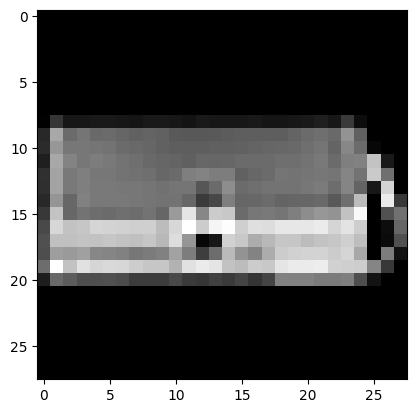

Prediction:  [6]
Label:  4


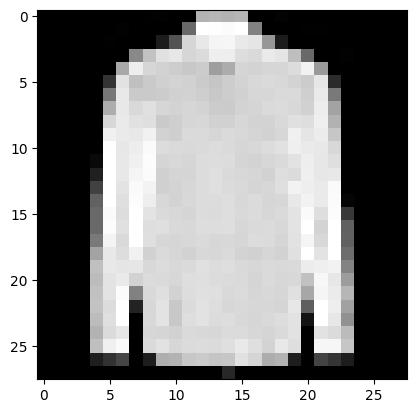

Prediction:  [4]
Label:  6


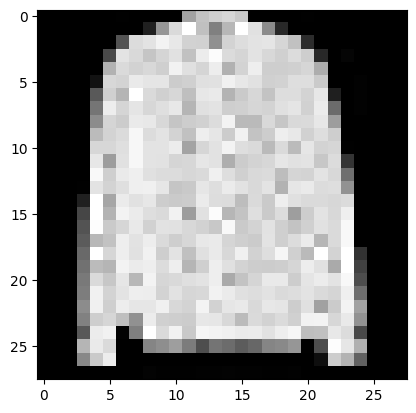

Prediction:  [0]
Label:  0


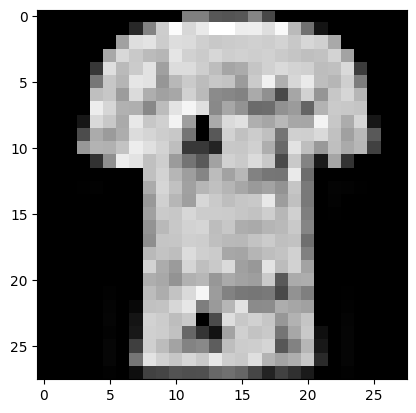

In [17]:
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
    
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(50, W1, b1, W2, b2)

<H2>Part 2: Error Analysis and Performance Improvements</H2>

You now will try to improve the model performance through, for example, different activation functions, learning rate cahnges, expanding the network complexity, regularization, and dropouts.  Implement these ideas for improvement and compare to the base model you completed in part 1.  The ideas may not improve the model, they may improve, give reasons why you did or did not succeed in makeing a better model.  You must implement at least three different models.

**It is crucial to provide reasoning behind what you do, or else no credit will be given.**

# Updates that I plan on implenting:

1. Model with:
    - increased learning rate/iterations
2. Model with:
    - increased learning rate/iterations
    - increased number of neurons
3. Model with:
    - increased learning rate/iterations
    - increased number of neurons
    - additional hidden layer

The follow will be the specific updates that I will add:
- Increae the learning rate / iterations
    - Alpha increased from 0.10 to 0.15
    - Iterations increased fro 500 to 800
- Increase the number of neurons
    - 20 > 30 hidden neurons (2nd layer)
    - New hidden layer (3rd layer) has 50 neurons
- Add an extra layer to the neural network
    - 1 hidden layer to 2 hidden layer

Note: I'm not gonna add docstrings to the re-implementation of the NN w/ a 3rd layer cause that's too much work lol.

## Reasoining for the changes:

In general, adding another layer to the network, makes the model deeper and able to have more room to learn more "complex" features and interactions in the data. While this can lead to overfitting, just adding one extra hidden layer can probably add more benefit in being able to learn the data at higher levels of abstraction.

Similarly, adding more neurons has a similar benefit as deepening the network of the deep learning model. Having more neurons enables the model with additional capacity to learn the more complex features of the data. Again, while this can lead to overfitting, the sligt increase in the number of neurons can probably do more good than harm! (I hope). 

For both of these changes, they do add more resource/computation load to the training step.

Lastly, I wanted to slightly increasea the learning rate (alpha) and the number of iterations. My thinking here is that during gradient descent, the deep learning model can take "bigger" steps to finding a minima to minimize the cost function. In addition, increasing the iterations allows the model more time/oppurtunity to find the optimal weights and biases that minimize the cost function. When choosing the new paramaters, I made sure not to increase them by too much. Doing so can lead to the model taking too many steps and never finding the minima. On the contrary, the increased iterations may cause an overfit as the data learns the data too well and converges too early. 



## Model 1: Increased learning rate / iterations

The follow will be the specific updates that I will add:
- Increae the learning rate / iterations
    - Alpha increased from 0.10 to 0.15
    - Iterations increased fro 500 to 800

In [18]:
NUM_HIDDEN_NEURONS = 20



W1, b1, W2, b2 = gradient_descent(
        X=X_train,
        y=Y_train,
        alpha=0.15,
        iterations=800,
        num_hidden_neurons=NUM_HIDDEN_NEURONS)

Iteration:  0
0.14875
Iteration:  10
0.42625
Iteration:  20
0.566875
Iteration:  30
0.61
Iteration:  40
0.64
Iteration:  50
0.66875
Iteration:  60
0.68625
Iteration:  70
0.7
Iteration:  80
0.711875
Iteration:  90
0.72125
Iteration:  100
0.73125
Iteration:  110
0.739375
Iteration:  120
0.743125
Iteration:  130
0.72125
Iteration:  140
0.7375
Iteration:  150
0.758125
Iteration:  160
0.764375
Iteration:  170
0.766875
Iteration:  180
0.769375
Iteration:  190
0.7725
Iteration:  200
0.77375
Iteration:  210
0.775625
Iteration:  220
0.779375
Iteration:  230
0.780625
Iteration:  240
0.7825
Iteration:  250
0.790625
Iteration:  260
0.791875
Iteration:  270
0.795
Iteration:  280
0.793125
Iteration:  290
0.795625
Iteration:  300
0.798125
Iteration:  310
0.801875
Iteration:  320
0.805
Iteration:  330
0.805
Iteration:  340
0.806875
Iteration:  350
0.809375
Iteration:  360
0.8125
Iteration:  370
0.8175
Iteration:  380
0.821875
Iteration:  390
0.82375
Iteration:  400
0.825625
Iteration:  410
0.826875
It

In [19]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
accuracy = get_accuracy(dev_predictions, Y_dev)

print(accuracy)

0.7625


## Model 2:
## Increased learning rates / iterations / neurons 

The follow will be the specific updates that I will add:
- Increae the learning rate / iterations
    - Alpha increased from 0.10 to 0.15
    - Iterations increased fro 500 to 800
- Increase the number of neurons
    - 20 > 50 hidden neurons (2nd layer)
    - New hidden layer (3rd layer) has 50 neurons

In [20]:
NUM_HIDDEN_NEURONS = 50

W1, b1, W2, b2 = gradient_descent(
        X=X_train,
        y=Y_train,
        alpha=0.15,
        iterations=800,
        num_hidden_neurons=NUM_HIDDEN_NEURONS)

Iteration:  0
0.115
Iteration:  10
0.558125
Iteration:  20
0.663125
Iteration:  30
0.70875
Iteration:  40
0.730625
Iteration:  50
0.74875
Iteration:  60
0.735625
Iteration:  70
0.7625
Iteration:  80
0.771875
Iteration:  90
0.779375
Iteration:  100
0.786875
Iteration:  110
0.794375
Iteration:  120
0.799375
Iteration:  130
0.80125
Iteration:  140
0.805
Iteration:  150
0.80875
Iteration:  160
0.81375
Iteration:  170
0.815625
Iteration:  180
0.82
Iteration:  190
0.826875
Iteration:  200
0.831875
Iteration:  210
0.83625
Iteration:  220
0.83875
Iteration:  230
0.84125
Iteration:  240
0.843125
Iteration:  250
0.85
Iteration:  260
0.85375
Iteration:  270
0.855625
Iteration:  280
0.859375
Iteration:  290
0.863125
Iteration:  300
0.865
Iteration:  310
0.86875
Iteration:  320
0.87
Iteration:  330
0.8725
Iteration:  340
0.875
Iteration:  350
0.876875
Iteration:  360
0.881875
Iteration:  370
0.8825
Iteration:  380
0.885625
Iteration:  390
0.889375
Iteration:  400
0.8925
Iteration:  410
0.89375
Iter

In [21]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
accuracy = get_accuracy(dev_predictions, Y_dev)

print(accuracy)

0.7575


## Model 3
## Increased learning rate / iterations / neurons / layers

The follow will be the specific updates that I will add:
- Increae the learning rate / iterations
    - Alpha increased from 0.10 to 0.15
    - Iterations increased fro 500 to 800
- Increase the number of neurons
    - 20 > 30 hidden neurons (2nd layer)
    - New hidden layer (3rd layer) has 50 neurons
- Add an extra layer to the neural network
    - 1 hidden layer to 2 hidden layer

In [22]:
# Increase the number of neurons in the hidden layers
NUM_HIDDEN_NEURONS = 30
NUM_HIDDEN_NEURONS2 = 50

# Add a layer to the neural netwrok
def init_params_v2(X: np.ndarray, y: np.ndarray, num_hidden_neurons1: int, num_hidden_neurons2: int) -> tuple:
    """
    Initialize the weights and biases for the neural network with two hidden layers.
    """
    input_length = X.shape[0]
    output_length = len(np.unique(y))

    W1 = np.random.rand(input_length, num_hidden_neurons1) - 0.5
    b1 = np.random.rand(num_hidden_neurons1, 1) - 0.5
    W2 = np.random.rand(num_hidden_neurons1, num_hidden_neurons2) - 0.5
    b2 = np.random.rand(num_hidden_neurons2, 1) - 0.5
    W3 = np.random.rand(num_hidden_neurons2, output_length) - 0.5
    b3 = np.random.rand(output_length, 1) - 0.5

    return W1, b1, W2, b2, W3, b3


def forward_prop_v2(W1, b1, W2, b2, W3, b3, X):
    """
    Compute the forward propagation step for a neural network with two hidden layers.
    """
    Z1 = W1.T @ X + b1
    A1 = ReLU(Z1)
    Z2 = W2.T @ A1 + b2
    A2 = ReLU(Z2)
    Z3 = W3.T @ A2 + b3
    A3 = softmax(Z3)

    return Z1, A1, Z2, A2, Z3, A3


def backward_prop_v2(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y):
    """
    Conduct backward propagation for a neural network with two hidden layers.
    """
    m = X.shape[1]
    one_hot_Y = one_hot(Y)

    dZ3 = A3 - one_hot_Y
    dW3 = A2 @ dZ3.T / m
    db3 = np.sum(dZ3, axis=1, keepdims=True) / m

    dZ2 = W3 @ dZ3 * ReLU_deriv(Z2)
    dW2 = A1 @ dZ2.T / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    dZ1 = W2 @ dZ2 * ReLU_deriv(Z1)
    dW1 = X @ dZ1.T / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    return dW1, db1, dW2, db2, dW3, db3


def update_params_v2(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    """
    Update the parameters of the neural network with two hidden layers using gradient descent.
    """
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    W3 -= alpha * dW3
    b3 -= alpha * db3

    return W1, b1, W2, b2, W3, b3


def gradient_descent_v2(X, y, alpha, iterations, num_hidden_neurons1, num_hidden_neurons2):
    """
    Perform gradient descent to optimize the parameters of the neural network with two hidden layers.
    """
    W1, b1, W2, b2, W3, b3 = init_params_v2(X, y, num_hidden_neurons1, num_hidden_neurons2)

    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop_v2(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop_v2(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, y)
        W1, b1, W2, b2, W3, b3 = update_params_v2(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)

        if i % 10 == 0:
            predictions = get_predictions(A3)
            accuracy = get_accuracy(predictions, y)
            print(f"Iteration {i}, Accuracy: {accuracy * 100:.2f}%")

    return W1, b1, W2, b2, W3, b3

# 3. Increase the learning rate / iterations
W1_v2, b1_v2, W2_v2, b2_v2, W3_v2, b3_v2 = gradient_descent_v2(
        X=X_train,
        y=Y_train,
        alpha=0.15,
        iterations=800,
        num_hidden_neurons1=NUM_HIDDEN_NEURONS,
        num_hidden_neurons2=NUM_HIDDEN_NEURONS2)


Iteration 0, Accuracy: 10.44%
Iteration 10, Accuracy: 40.56%
Iteration 20, Accuracy: 57.38%
Iteration 30, Accuracy: 63.69%
Iteration 40, Accuracy: 63.50%
Iteration 50, Accuracy: 66.81%
Iteration 60, Accuracy: 68.00%
Iteration 70, Accuracy: 69.06%
Iteration 80, Accuracy: 70.19%
Iteration 90, Accuracy: 71.12%
Iteration 100, Accuracy: 72.19%
Iteration 110, Accuracy: 73.19%
Iteration 120, Accuracy: 73.69%
Iteration 130, Accuracy: 74.31%
Iteration 140, Accuracy: 74.81%
Iteration 150, Accuracy: 75.81%
Iteration 160, Accuracy: 77.69%
Iteration 170, Accuracy: 77.31%
Iteration 180, Accuracy: 75.62%
Iteration 190, Accuracy: 77.88%
Iteration 200, Accuracy: 77.62%
Iteration 210, Accuracy: 79.69%
Iteration 220, Accuracy: 80.88%
Iteration 230, Accuracy: 80.44%
Iteration 240, Accuracy: 79.25%
Iteration 250, Accuracy: 81.00%
Iteration 260, Accuracy: 81.31%
Iteration 270, Accuracy: 81.38%
Iteration 280, Accuracy: 81.81%
Iteration 290, Accuracy: 82.94%
Iteration 300, Accuracy: 83.00%
Iteration 310, Accu

In [23]:
def make_predictions_v2(X, W1, b1, W2, b2, W3, b3):
    """
    Makes predictions using the trained neural network.
    """
    _, _, _, A2, _, A3 = forward_prop_v2(W1, b1, W2, b2, W3, b3, X) 
    Z3 = W3.T @ A2 + b3  
    A3 = ReLU(Z3) 
    A2_new = softmax(A3) 
    predictions = get_predictions(A2_new) 
    return predictions


In [24]:
dev_predictions_v2 = make_predictions_v2(X_dev, W1_v2, b1_v2, W2_v2, b2_v2, W3_v2, b3_v2)
accuracy_v2 = get_accuracy(dev_predictions_v2, Y_dev)

print(accuracy_v2)

0.7475


Prediction:  [8]
Label:  8


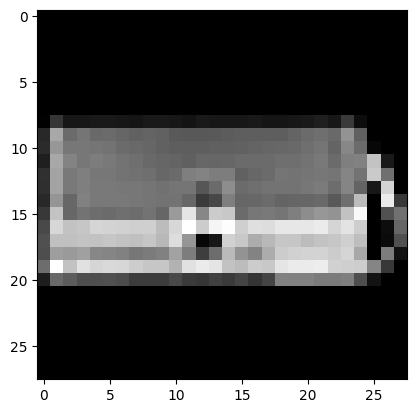

Prediction:  [6]
Label:  4


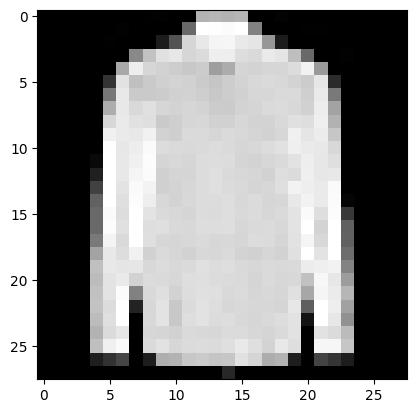

Prediction:  [4]
Label:  6


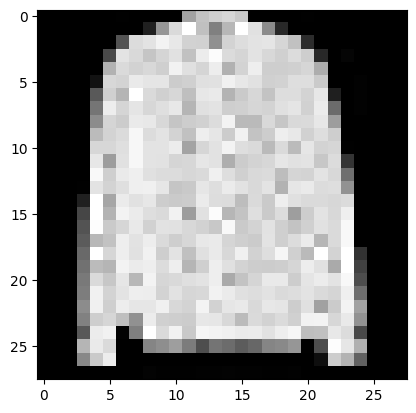

Prediction:  [0]
Label:  0


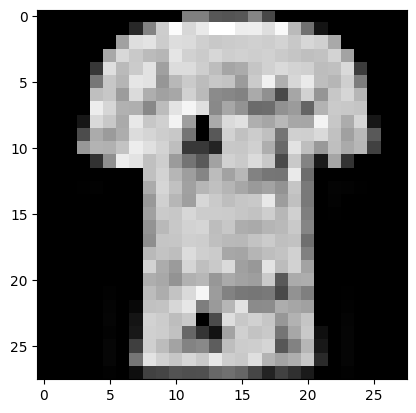

In [25]:
def test_prediction_v2(index, W1, b1, W2, b2, W3, b3):
    """
    Test the neural network prediction on a given image from the training set.
    """
    # Extract the image to test
    current_image = X_train[:, index, None]
    
    # Get the prediction from the model
    prediction = make_predictions_v2(current_image, W1, b1, W2, b2, W3, b3)
    
    # Get the true label for the sample
    label = Y_train[index]
    
    # Print the prediction and true label
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    # Reshape the image and scale to original pixel values
    current_image = current_image.reshape((28, 28)) * 255
    
    # Plot the image
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

# Test predictions for the first few samples
test_prediction_v2(0, W1_v2, b1_v2, W2_v2, b2_v2, W3_v2, b3_v2)
test_prediction_v2(1, W1_v2, b1_v2, W2_v2, b2_v2, W3_v2, b3_v2)
test_prediction_v2(2, W1_v2, b1_v2, W2_v2, b2_v2, W3_v2, b3_v2)
test_prediction_v2(50, W1_v2, b1_v2, W2_v2, b2_v2, W3_v2, b3_v2)


# Results

Base Model Accuracy: __0.7675__
  - 1 hidden layer
    - 20 neurons
  - alpha = 0.10
  - iterations = 500
  - activation = ReLu
Model 1 (+ alpha/iterations): __0.785__
  - 1 hidden layer
    - 20 neurons
  - alpha = 0.15
  - iterations = 800
  - activation = ReLu
Model 2 (+ alpha/iterations/neurons): __0.7775__
  - 1 hidden layer
    - 50 neurons
  - alpha = 0.15
  - iterations = 800
  - activation = ReLu
Model 3 (+ alpha/iterations/neurons/layers): __0.7625__
  - 2 hidden layers
    - 30 neurons
    - 50 neurons
  - alpha = 0.15
  - iterations = 800
  - activation = ReLu


Honestly, the results were very interesting. I totally expected the model with all the changes to do the best. However, it looks like the more complexity I added, the worst the model performed. The only model that didn't improve on the base model performance was the last, most complex neural network! I still think my initial intuition for adding these changes is still sound - espeacially as I did note the drawbacks of each change.

As I mentioned in the reasoining for my "improvements", these results probably suggest some level of overfitting and poor generalizability. On the other hand, the best out of the three experimental models was the most simple, base model but with slight tweaks to the learning rate and iterations. The results show a significant improvement over the base model (1.75 percent increase) suggesting solid generalization. This model isn't perfect or performant really but I feel like it's honestly not bad considering this is all done with numpy. The folks that discovered and developed this is pretty wild. 

The main takeaway from this, aside from implementing the neural network from scratch is that complexity != results. I think at the end of the day, good quality data and a deep learning model that is moderately tuned/optimized is the way to go.